# Exploratory Data Analysis

# Reading in Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.cm as cm  # colormaps for visualization

import joypy  # ridgeline chart
import numpy as np

# interactive visualization
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px

In [2]:
# set filepath to processed data
filepath = '../data/processed/ga_export_processed.xlsx'

#create separate dataframes for each table
traffic_source = pd.read_excel(filepath, sheet_name='traffic_source')
geo_location = pd.read_excel(filepath, sheet_name='geo_location')
device = pd.read_excel(filepath, sheet_name='device')
demos = pd.read_excel(filepath, sheet_name='demos')

#set index for dataframes with datetime field
traffic_source.set_index(traffic_source['month_year_dt'], inplace=True)
device.set_index(device['month_year_dt'], inplace=True)

#sort the dataframes that have datetime values in ascending order by datetime
traffic_source = traffic_source.sort_index()
device = device.sort_index()

# Visualizing Channel Characteristics

I want to explore what the distribution of sessions, bounce rate, and the email capture conversion rate overall. I also want to see what these look like over time in aggregate, and when separated by channel.

## Overall Feature Distributions

### Feature Histograms

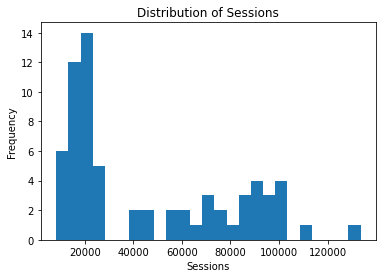

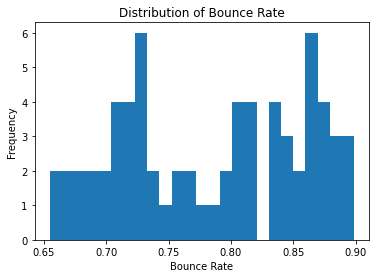

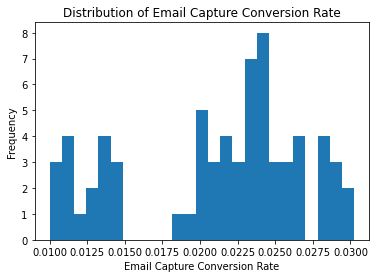

In [3]:
for col in ['Sessions', 'Bounce Rate', 'Email Capture Conversion Rate']:
    traffic_source.plot(y=col, kind='hist', bins=25, legend=False)
    plt.title('Distribution of {c}'.format(c=col))
    plt.xlabel(col)

### Feature Ridgeline Plots

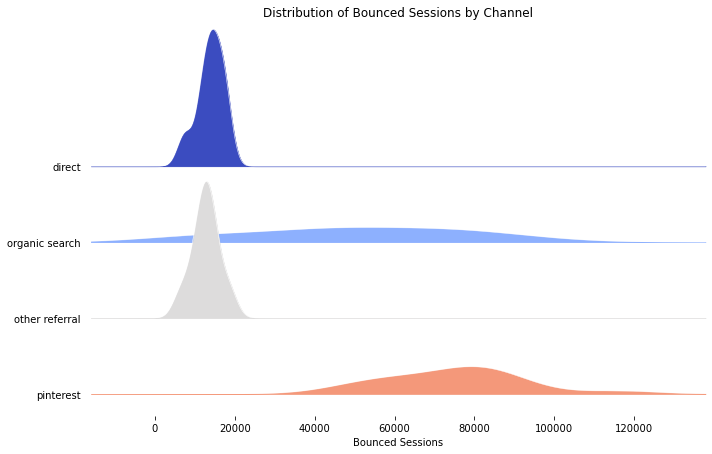

In [4]:
fig, axes = joypy.joyplot(traffic_source,
                          by='Traffic Channel',
                          column='bounced_sessions',
                          overlap=1.8,
                          colormap=cm.coolwarm,
                          linecolor='w',
                          linewidth=.5,
                          figsize=(10, 6))
plt.title('Distribution of Bounced Sessions by Channel');
plt.xlabel('Bounced Sessions');


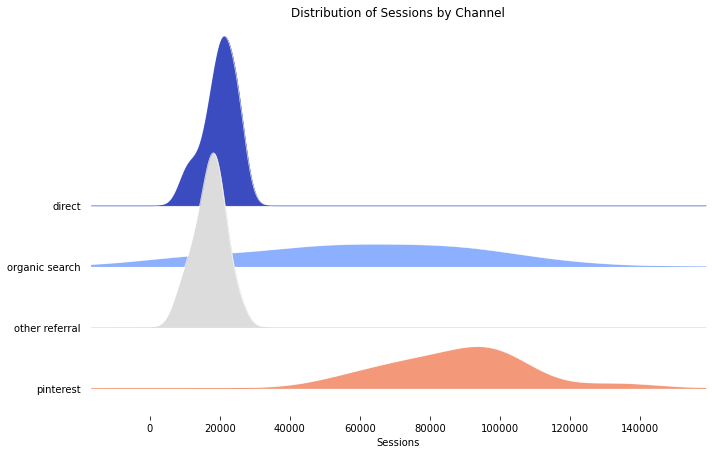

In [5]:
fig, axes = joypy.joyplot(traffic_source,
                          by='Traffic Channel',
                          column='Sessions',
                          overlap=3,
                          colormap=cm.coolwarm,
                          linecolor='w',
                          linewidth=.5,
                          figsize=(10, 6))
plt.title('Distribution of Sessions by Channel');
plt.xlabel('Sessions');

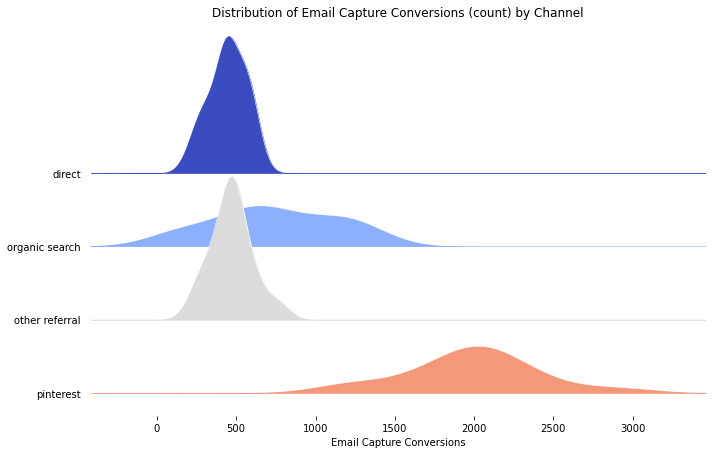

In [6]:
fig, axes = joypy.joyplot(traffic_source,
                          by='Traffic Channel',
                          column='email_conv_sessions',
                          overlap=2,
                          colormap=cm.coolwarm,
                          linecolor='w',
                          linewidth=.5,
                          figsize=(10, 6))
plt.title('Distribution of Email Capture Conversions (count) by Channel');
plt.xlabel('Email Capture Conversions');

In [7]:
print(
    'Mean monthly sessions across all channels: ',
    np.round(
        traffic_source.pivot(index='month_year_dt',
                             columns='Traffic Channel',
                             values='Sessions').sum(axis=1).mean(), 0))

print(
    'Mean monthly bounce rate across all channels: ',
    np.round(
        traffic_source.pivot(index='month_year_dt',
                             columns='Traffic Channel',
                             values='Bounce Rate').mean(axis=1).mean() * 100,
        0),"%")

Mean monthly sessions across all channels:  185381.0
Mean monthly bounce rate across all channels:  78.0 %


## Thoughts on Overall Distributions

**Bounced Sessions**
* The count of bouncing sessions is quite low for direct traffic, implying that those who were seeking the content out directly were engaging really well with the site once they got there.
* Organic search is high at 50-85% across all months, centering around 75% overall.. If session duration is also low, this may mean there is an issue with the content. It would imply users are arriving, not really engaging, and then leaving quickly.

* Other referral bounced sessions are somewhat bimodal. The two modes center at ~35% and ~52%. Perhaps plotting this over time will yield more insight. Question: What does the bounce rate look like broken out by referral source? Is the bounce rate consistent across sources or is this plot hinting that some sources are resulting in high bounce rates vs others?

* Pinterest is bouncing most often and accounts for a majority of bounced sessions.

**Sessions**
*  Direct and other referral channels are accounting for about 1/4 of pinterest channel sessions
*  Organic search seems highly dispersed, displaying really high variability. Viewing this across a time axis will likely reveal that this value has changed over time (or is highly variable in general)

**Email Capture Conversions**
* The distribution of conversions across months in the data are quite narrow for other referral and direct channels, indicating relatively stable conversion scale (count of sessions with a conversion) over time

## Visualizing Channels and Metrics

### Metrics Across Time by channel

In [8]:
# sessions
color_sequence = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
fig = px.line(traffic_source,
              y='Sessions',
              color='Traffic Channel',
              color_discrete_sequence=color_sequence)


fig.update_layout(title="Sessions Over Time by Channel",
                  xaxis_title="Month-Year",
                  yaxis_title="Total Sessions")


# exploring adding an n-period rolling mean view but it gets busy quickly

# a = traffic_source[traffic_source['Traffic Channel'] == 'pinterest']['Sessions'].rolling(4, min_periods=1).mean()
# fig.add_trace(go.Scatter(x=a.index, y=a, name='Moving Average of Sessions (3 month)',
#                          line=dict(color=color_sequence[3], width=1, dash='dot')))

#plot, save to file
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/sessions_by_channel.html")

# bounce rate
fig = px.line(traffic_source,
              y='Bounce Rate',
              color='Traffic Channel',
              color_discrete_sequence=color_sequence)
fig.update_layout(title="Bounce Rate Over Time by Channel",
                  xaxis_title="Month-Year",
                  yaxis_title="Bounce Rate")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/bounce_rate_by_channel.html")

fig = px.line(traffic_source,
              y='Email Capture Conversion Rate',
              color='Traffic Channel',
              color_discrete_sequence=color_sequence)
fig.update_layout(title="Email Capture Conversion Rate Over Time by Channel",
                  xaxis_title="Month-Year",
                  yaxis_title="Email Capture Conversion Rate")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/conversions_by_channel.html")


### Proportion of Monthly Traffic by Channel Over Time

In [9]:
# copy table for transformation
t_prop = traffic_source.copy()

for row_num, row in enumerate(traffic_source.iterrows()):
    # the sessions total should be the sessions by that channel (on that row, i) over all sessions per month

    # t prop takes the sessions per channel for a given month (sessions at a particular row) and divides it by the sum of sessions per that month
    # the loop then writes that proportion to the position where the original value was drawn from in the copy of the df
    t_prop.loc[row[0], 'pct_sessions'] = np.round(
        traffic_source.loc[row[0], 'Sessions'] / traffic_source[
            traffic_source['month_year_dt'] == row[1][5]]['Sessions'].sum(),
        2) * 100

In [10]:
fig = px.line(t_prop, y='pct_sessions', color='Traffic Channel')
fig.update_layout(
    title="Sessions as a Proportion of their Monthly Sum by Channel",
    xaxis_title="Month-Year",
    yaxis_title="% of This Month's Total Sessions")
py.offline.iplot(fig)

### Visualizing Metrics in Terms of Sessions

In [11]:
color_sequence = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']


# bounce rate
fig = px.line(traffic_source,
              y='bounced_sessions',
              color='Traffic Channel',
              color_discrete_sequence=color_sequence)
fig.update_layout(title="Count of Bounced Sessions Over Time by Channel",
                  xaxis_title="Month-Year",
                  yaxis_title="Count of Bounced Sessions")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/count_bounced_sessions_by_channel.html")

fig = px.line(traffic_source,
              y='email_conv_sessions',
              color='Traffic Channel',
              color_discrete_sequence=color_sequence)
fig.update_layout(title="Email Capture Conversions Over Time by Channel",
                  xaxis_title="Month-Year",
                  yaxis_title="Count of Email Capture Conversions")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/count_email_conversions_by_channel.html")


### Percent Change in Metrics By Channel

Converting to percent change allows comparing values against their prior raw value. It gives a more clear sense of the scale of the change throughout time, since metrics are transformed into one unit (pct change) instead of the different units present in the raw data.

In [12]:
# plot pct change
# looped implementation due to the mechanics of the .pct_change method and the datetime array index

for metric in ['Sessions', 'Bounce Rate', 'Email Capture Conversion Rate']:

    # create a figure for each available of metric
    fig = go.Figure()

    # for each channel type, create a dataframe with the pct change in that one metric, filtered by the channel type
    for position, channel in enumerate(
        ['direct', 'organic search', 'other referral', 'pinterest']):

        df = traffic_source[traffic_source['Traffic Channel'] ==
                            channel].reset_index(drop=True)
        df2 = df[[metric]].pct_change() * 100

        #append the month_year_dt for x axis in plots
        df2['month_year_dt'] = df['month_year_dt']

        #add as a trace to the figure for that metric
        fig.add_trace(
            go.Scatter(x=df2['month_year_dt'],
                       y=df2.loc[:, metric],
                       mode='lines',
                       name=channel,
                       line=dict(color=color_sequence[position], width=2),
                       legendgroup=channel,
                       showlegend=True))

    fig.update_layout(title="Percent Change in {m} Over Time".format(m=metric),
                      xaxis_title="Month-Year",
                      yaxis_title="Percent Change (Month over Month %) ")

    fig.add_trace(
        go.Scatter(x=df2['month_year_dt'],
                   y=[0] * 17,
                   mode='lines',
                   name='Zero Pct Change',
                   line=dict(color='black', width=1.5, dash='dot')))
    fig.show()

## Takeaways: Channel Trends over Time

**Sessions**

* Pinterest traffic was responsible for the most sessions early on, but organic search has grown to compete with pinterest traffic. Pinterest sessions and organic search sessions seem to be negatively correlated, where when one goes up, the other goes down as of Nov 2019 onward.
    
    Question : What mechanism would be driving this trend or is it just spurious?

* Direct and Other referral sessions tend to be more consistent over time, but direct traffic seems to be on a negative trend over the past few months.

**Bounce Rate**

* Organic search and pinterest bounce rates are very high across time, in the 80-90% range

**Email Capture Conversion Rate**

* Email capture is highest in the other referral channel, followed by the pinterest and direct channels which have similar values generally. 
* Organic search has comparatively low email capture conversion and trends only between 1% and 1.5%


# Visualizing Geographies and Metrics

### Sessions by Country

In [13]:
# raw sessions among top 10 countries
fig = px.bar(geo_location.sort_values(by='Sessions',
                                      ascending=False).iloc[0:10, :],
             x="Country",
             y=["Sessions"],
             title='10 Countries with Highest Sessions by Count')
fig.show()

# as pct of total
fig2 = px.bar(
    geo_location.sort_values(by='pct_overall_sessions', ascending=False).iloc[0:10, :],
    x="Country",
    y="pct_overall_sessions",
    title='10 Countries with Highest Sessions by Percentage Composition')

fig2.update_layout(yaxis=dict(
                      tickmode='array',
                      tickvals=[0, 0.20, .40, .6, .8, 1],
                      ticktext=['0', '20%', '40%', '60%', '80%', '100%']))
fig2.show()
fig2.write_html("../reports/figures/plotly/pct_sessions_by_country.html")


### Session Duration Characteristics Value

In [14]:
print(
    'Weighted Avg. of all session times: ',
    np.round(
        geo_location['total_duration'].sum() / geo_location['Sessions'].sum(),
        2))

Weighted Avg. of all session times:  39.9


In [15]:
# which countries make up 95% of sessions

for c in [5]:
    print('{c} countries account for {p}% of sessions: \n'.format(
        c=c,
        p=np.round(
            geo_location.sort_values(
                by='Sessions', ascending=False)['pct_overall_sessions'][0:c].sum(),
            2) * 100))

# create dataframe with just these countries
geo_small = geo_location.iloc[0:5, :]

# print countries
[print(i) for i in geo_small['Country']];

5 countries account for 95.0% of sessions: 

United States
Canada
United Kingdom
Australia
India


In [16]:
# as pct of total
fig2 = px.bar(geo_small,
              x="Country",
              y="Avg. Session Duration",
              title='Average Session Duration by Country (95% of Sessions)')
fig2.show()
fig2.write_html("../reports/figures/plotly/avg_session_duration_95_pct_countries.html")


# Visualizing Device Characteristics

In [17]:
# Proportion of sessions by device: ##.# %
print('Proportion of total sessions by device:\n---------------')
np.round(
    device.pivot(columns='Device', values='Sessions').sum(axis=0) /
    device.pivot(columns='Device', values='Sessions').sum().sum() * 100, 2)

Proportion of total sessions by device:
---------------


Device
desktop    20.95
mobile     73.16
tablet      5.89
dtype: float64

### Metrics by Device Over Time

In [18]:
# sessions
fig = px.line(device,
              y='Sessions',
              color='Device',
              color_discrete_sequence=color_sequence[0:3])
fig.update_layout(title="Sessions Over Time by Device",
                  xaxis_title="Month-Year",
                  yaxis_title="Total Sessions")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/sessions_by_device.html")


# bounce rate
fig = px.line(device,
              y='Bounce Rate',
              color='Device',
              color_discrete_sequence=color_sequence[0:3])
fig.update_layout(title="Bounce Rate Over Time by Device",
                  xaxis_title="Month-Year",
                  yaxis_title="Bounce Rate")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/bounce_rate_by_device.html")

fig = px.line(device,
              y='Email Capture Conversion Rate',
              color='Device',
              color_discrete_sequence=color_sequence[0:3])
fig.update_layout(title="Email Capture Conversion Rate Over Time by Device",
                  xaxis_title="Month-Year",
                  yaxis_title="Email Capture Conversion Rate")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/email_conversion_by_device.html")


### Metrics by Device In Terms of Sessions

In [19]:


# bounce rate
fig = px.line(device,
              y='bounced_sessions',
              color='Device',
              color_discrete_sequence=color_sequence[0:3])
fig.update_layout(title="Count of Bounced Sessions Over Time by Device",
                  xaxis_title="Month-Year",
                  yaxis_title="Bounced Sessions")
py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/bounced_session_count_by_device.html")


fig = px.line(device,
              y='email_conv_sessions',
              color='Device',
              color_discrete_sequence=color_sequence[0:3])
fig.update_layout(title="Sessions with Email Capture Conversion Over Time by Device",
                  xaxis_title="Month-Year",
                  yaxis_title="Count of Sessions with Email Capture Conversion")

py.offline.iplot(fig)
fig.write_html("../reports/figures/plotly/email_conversions_by_device.html")


## Takeaways: Metrics by Device

**Sessions**

* Mobile devices account for the large majority of sessions (73% of all sessions across all months)

**Bounce Rate**
* Mobile device access has a very high bounce rate, implying content is either poorly formatted for mobile and/or that there isnt a lot of movement through the site.
* Mobile bounce rate is less variable than other devices. 
* Question: Why is tablet bounce rate so variable?
* Desktop bounce rate was nice and low, but is creeping back up past its average across 2019.
* Question: Did anything change with the content and design of the site in the new calendar year?

**Email Capture Conversions**
* Mobile email capture conversion rate is just under 2% on average, but is on the rise more recently. 
* Question: Tablet email capture conversion is non-existant right now. Is that broken in analytics, for users, or both?

**Overall**

* Mobile device access is most common, but the conversion rate is lower than desktop which has a higher email capture conversion rate. Question: Is the content poorly formatted for mobile consumption?
* Bounce rates for tablets peaked in December and then email conversion rate completely dropped to zero in January and onward. Question: Is the email conversion process broken on tablets? 
* Email Capture conversion is relatively consistent over time for mobile and desktop. With that, it may be easier to focus on streamlining the path for the conversion for mobile users
* Question: What happened in January when bounce rate when way down for desktop users?
* Question: Why might bounce rate be climbing among desktop users?

# Visualizing Demographic Characteristics

In [20]:
#create aggregation across gender indexed by age
d_pivot = demos.pivot(index='Age', columns='Gender', values='Users')

#convert each value to a proportion of total users
d_pct = d_pivot / d_pivot.sum().sum()

# flip sign of males, as they are much lower than females among users
d_pct['male'] = d_pct['male'] * -1

#make more human readable with percentage values
d_pct = np.round(d_pct * 100, 1)

In [21]:
print('Ratio of female to male users across all age groups:',
      np.round(d_pivot['female'].sum() / d_pivot['male'].sum(), 0), ": 1")

Ratio of female to male users across all age groups: 10.0 : 1


## Percentage of Users by Age and Gender

In [22]:
fig = go.Figure()

category_order = ['female', 'male']

colors = ['#5ab4ac', '#d8b365']

for pos, column in enumerate(d_pct.columns):
    fig.add_trace(
        go.Bar(
            x=d_pct[column],
            y=d_pct.index,
            name=column,
            orientation='h',
            marker_color=colors[pos],
        ))

fig.update_layout(barmode='relative',
                  title='Composition of Total Users By Age and Gender',
                  xaxis_title='Percent of Total Users',
                  yaxis_title='Age Group',
                  xaxis=dict(
                      tickmode='array',
                      tickvals=[-2.5, 0, 5, 10, 15, 20, 25],
                      ticktext=['2.5', '0', '5', '10', '15', '20', '25']))

fig.show()


# Relationships Between Metrics

## Channel

In [23]:
fig = px.scatter(
    traffic_source,
    x="Bounce Rate",
    y="Email Capture Conversion Rate",
    color="Traffic Channel",
    size='Sessions',
    #                  hover_data=['Month of Year', 'Traffic Channel']
)

fig.update_layout(
    title=
    'Email Capture Conversion Rate x Bounce Rate (Point Size based on Sessions)',
    xaxis_title='Bounce Rate',
    yaxis_title='Email Capture Conversion Rate')
fig.show()
fig.write_html("../reports/figures/plotly/scatter_email_capture_bounce_rate_channel.html")


## Geographies

In [24]:
fig = px.scatter(geo_location[geo_location.Sessions > 100],
                 x="Bounce Rate",
                 y="Email Capture Conversion Rate",
                 size='Sessions',
                 color='Sessions',
                 hover_data=['Sessions'],
                 color_continuous_scale=px.colors.sequential.Magenta)

fig.update_layout(
    title=
    'Email Capture Conversion Rate x Bounce Rate (Among Countries with 100+ Sessions)',
    xaxis_title='Bounce Rate',
    yaxis_title='Email Capture Conversion Rate')
fig.show()

## Devices

In [25]:
fig = px.scatter(
    device,
    x="Bounce Rate",
    y="Email Capture Conversion Rate",
    size='Sessions',
    color='Device',
    #                  hover_data=['Sessions'],
    #                  color_continuous_scale=px.colors.sequential.Magenta
)

fig.update_layout(
    title=
    'Email Capture Conversion Rate x Bounce Rate Across Devices(sized by sessions)',
    xaxis_title='Bounce Rate',
    yaxis_title='Email Capture Conversion Rate')
fig.show()
fig.write_html("../reports/figures/plotly/scatter_email_capture_bounce_rate_device.html")
